# Lets reconstruct real data

In [169]:
# Load the required libraries
import time, math, os, shutil
import torch
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from VolumeRaytraceLFM.abstract_classes import BackEnds
from VolumeRaytraceLFM.birefringence_implementations import BirefringentVolume, BirefringentRaytraceLFM
from plotting_tools import plot_birefringence_lines, plot_birefringence_colorized
from VolumeRaytraceLFM.optic_config import volume_2_projections
import datetime
# %matplotlib notebook
# Select backend: requires pytorch to calculate gradients
backend = BackEnds.PYTORCH

## Select a directory containing the files, 
### The files should already be rectified, so we have a known number of pixels per microlens

Loaded images with shape: torch.Size([2096, 2064])


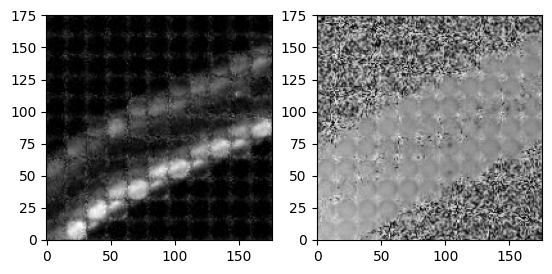

In [170]:
# Delect data path
ds = 'celegance'
if ds == 'celegance':
    data_path = "objects/experimental/SM_2022_1214_1541_1 celegan pair LF/Pos0/"
else:   
    data_path = "objects/experimental/SM_2022_1214_1446_1 spiral LF/Pos0/"
# Load data
retardance_path = f"{data_path}/Rectified_Retardance.png"
azimuth_path = f"{data_path}/Rectified_Azimuth.png"
ret_image_measured = torch.from_numpy(np.array(Image.open(retardance_path)).astype(np.float32))
azim_image_measured = torch.from_numpy(np.array(Image.open(azimuth_path)).astype(np.float32))
print(f'Loaded images with shape: {ret_image_measured.shape}')

# Normalize data
ret_image_measured /= ret_image_measured.max()
ret_image_measured *= 0.01
azim_image_measured *= math.pi / azim_image_measured.max()

# Lets load metadata
with open(f'{data_path}/metadata.txt', 'r') as stream:
    metadata = stream.read()
metadata =  json.loads(metadata)

# And create birefrigence object
# Get optical parameters template
optical_info = BirefringentVolume.get_optical_info_template()
# Alter some of the optical parameters
optical_info['volume_shape'] = [21,27,27]
optical_info['axial_voxel_size_um'] = 1.0


# MLA data
optical_info['pixels_per_ml']       = math.ceil(metadata['calibrate']['ulens_pitch'] / metadata['calibrate']['pixel_size'])
optical_info['n_micro_lenses']      = 11
optical_info['n_voxels_per_ml']     = 1
optical_info['axial_voxel_size_um'] = 1
# Optics data
optical_info['M_obj']           = metadata['calibrate']['objective_magnification']
optical_info['na_obj']          = metadata['calibrate']['objective_na']
optical_info['n_medium']        = metadata['calibrate']['medium_index']
optical_info['wavelength']      = metadata['calibrate']['center_wavelength']
optical_info['camera_pix_pitch']= metadata['calibrate']['pixel_size']

# Helper function to crop interesting part of the volume
def crop_volume(volume):
    start = optical_info['volume_shape'][-1]//2-optical_info['n_micro_lenses']//2
    end = start + optical_info['n_micro_lenses']
    return volume[:,start:end, start:end]

# Crop data based on n_micro_lenses and n_voxels_per_ml
start_ml = [54,50]
start_coords = [sc * optical_info['pixels_per_ml'] for sc in start_ml]
end_coords = [sc + optical_info['n_micro_lenses'] * optical_info['pixels_per_ml'] for sc in start_coords ]

ret_image_measured = ret_image_measured[start_coords[0]:end_coords[0], start_coords[1] : end_coords[1]]
azim_image_measured = azim_image_measured[start_coords[0]:end_coords[0], start_coords[1] : end_coords[1]]

# Plot images
plt.subplot(1,2,1)
plt.imshow(ret_image_measured.numpy(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(azim_image_measured.numpy(), cmap='gray')

## Lets define reconstruction settings


In [171]:
# which loss to use?
loss = 'vector' # vector, L1all, L1_cos, 
# Do we add regularization?
reg = 'unit' # unit, L1, L2
training_params = {
    'n_epochs' : 1001,                      # How long to train for
    'azimuth_weight' : .5,                  # Azimuth loss weight
    'regularization_weight' : 0.0001,     # Regularization weight
    'azimuth_lr_multiplier' : 20000,     # Learning rate multiplier
    'lr' : 1e-4,                            # Learning rate
    'output_posfix' : f'{ds}_{loss}_reg{reg}'        # Output file name posfix
}

# Display settings
# azimuth_plot_type = 'lines'
azimuth_plot_type = 'hsv'

# Create output directory
now = datetime.datetime.now()
dt_string = now.strftime("%Y%m%d_%H_%M_%S")
output_dir = f'reconstructions_real_data/{dt_string}_recons_{optical_info["volume_shape"][0]}' \
                + f'x{optical_info["volume_shape"][1]}x{optical_info["volume_shape"][2]}__{training_params["output_posfix"]}'
os.makedirs(output_dir, exist_ok=True)
torch.save({'optical_info' : optical_info,
            'training_params' : training_params}, f'{output_dir}/parameters.pt')
print(f'Output path: {output_dir}')
# Copy this script to the output directory
shutil.copy('Reconstruct_experimental_data.ipynb', f"{output_dir}/Reconstruct_experimental_data.ipynb")

Output path: reconstructions_real_data/20230503_15_19_17_recons_21x27x27__celegance_vector_regunit


'reconstructions_real_data/20230503_15_19_17_recons_21x27x27__celegance_vector_regunit/Reconstruct_experimental_data.ipynb'

## Prepare birefringence processor

In [172]:

# Create a Birefringent Raytracer
rays = BirefringentRaytraceLFM(backend=backend, optical_info=optical_info)

# Compute the rays and use the Siddon algorithm to compute the intersections
#   with voxels.
# If a filepath is passed as argument, the object with all its calculations
#   get stored/loaded from a file.
startTime = time.time()
rays.compute_rays_geometry()
executionTime = (time.time() - startTime)
print('Ray-tracing time in seconds: ' + str(executionTime))

# Force cpu, as for now cpu is faster
device = "cpu"
print(f'Using computing device: {device}')
rays = rays.to(device)

Ray-tracing time in seconds: 0.024929046630859375
Using computing device: cpu


## Create a volume estimate, which we will reconstruct


In [173]:

############# 
# Let's create an optimizer
# Initial guess:
# Important is that the range of random voxels should be close to the expected birefringence
volume_estimation = BirefringentVolume(backend=backend, optical_info=optical_info, \
                                volume_creation_args = {'init_mode' : 'random'})

# Let's rescale the random to initialize the volume
volume_estimation.Delta_n.requires_grad = False
volume_estimation.optic_axis.requires_grad = False
volume_estimation.Delta_n *= 0.00001
# And mask out volume that is outside FOV of the microscope
mask = rays.get_volume_reachable_region()
volume_estimation.Delta_n[mask.view(-1)==0] = 0
volume_estimation.Delta_n.requires_grad = True
volume_estimation.optic_axis.requires_grad = True

# Indicate to this object that we are going to optimize Delta_n and optic_axis
volume_estimation.members_to_learn.append('Delta_n')
volume_estimation.members_to_learn.append('optic_axis')
volume_estimation = volume_estimation.to(device)

trainable_parameters = volume_estimation.get_trainable_variables()

# As delta_n has much lower values than optic_axis, we might need 2 different learning rates
parameters = [{'params': trainable_parameters[0], 'lr': training_params['lr'] * training_params['azimuth_lr_multiplier']}, # Optic axis
              {'params': trainable_parameters[1], 'lr': training_params['lr']}]      # Delta_n

# Create optimizer and loss function
optimizer = torch.optim.Adam(parameters, lr=training_params['lr'])

## Let's reconstruct

In [174]:
# To test differentiability let's define a loss function L = |ret_image_torch|, and minimize it
losses = []
data_term_losses = []
regularization_term_losses = []
# plt.ion()
figure = plt.figure(figsize=(10,10))
plt.rcParams['image.origin'] = 'lower'


# Create weight mask for the azimuth
# as the azimuth is irrelevant when the retardance is low, lets scale error with a mask
azimuth_damp_mask = (ret_image_measured / ret_image_measured.max()).detach()

# Vector difference GT
if loss=='vector':
    co_gt, ca_gt = ret_image_measured*torch.cos(azim_image_measured), ret_image_measured*torch.sin(azim_image_measured)
for ep in tqdm(range(training_params['n_epochs']), "Minimizing"):
    # Reset gradients so we can compute them again
    optimizer.zero_grad()

    # Forward project
    ret_image_current, azim_image_current = rays.ray_trace_through_volume(volume_estimation)
    # Vector difference
    if loss=='vector':
        co_pred, ca_pred = ret_image_current*torch.cos(azim_image_current), ret_image_current*torch.sin(azim_image_current)
        data_term = ((co_gt-co_pred)**2 + (ca_gt-ca_pred)**2).mean()
    elif loss=='L1_cos':
        data_term = (ret_image_measured - ret_image_current).abs().mean() + \
            training_params['azimuth_weight'] * torch.cos(azim_image_measured - azim_image_current).abs().mean()
    elif loss=='L1all':
        data_term = (ret_image_measured - ret_image_current).abs().mean() + \
        (2 * (1 - torch.cos(azim_image_measured - azim_image_current)) * azimuth_damp_mask).mean()
        # L1 for angles

    if reg=='L1':
    # L1 or sparsity 
        regularization_term = volume_estimation.Delta_n.abs().mean()
    # L2 or sparsity 
    elif reg=='L2':
        regularization_term = (volume_estimation.Delta_n**2).mean()
    # Unit length regularizer
    elif reg=='unit':
        regularization_term  = (1-(volume_estimation.optic_axis[0,...]**2+volume_estimation.optic_axis[1,...]**2+volume_estimation.optic_axis[2,...]**2)).abs().mean()
    else:
        regularization_term = torch.zeros([1], device=device)
    # Total variation regularization would be computing the 3D spatial derivative of the volume and apply an L1 norm to it.

    L = data_term + training_params['regularization_weight'] * regularization_term

    # Calculate update of the my_volume (Compute gradients of the L with respect to my_volume)
    L.backward()

    # Apply gradient updates to the volume
    optimizer.step()


    losses.append(L.item())
    data_term_losses.append(data_term.item())
    regularization_term_losses.append(regularization_term.item())

    azim_image_out = azim_image_current.detach()

    if ep%50==0:
        # Crop interesting part of the volume
        plt.clf()
        plt.subplot(4,4,1)
        plt.imshow(ret_image_measured.detach().cpu().numpy())
        plt.colorbar(fraction=0.05, pad=0.04)
        plt.title('Measured Retardance')
        plt.subplot(4,4,2)
        # plt.imshow(azim_image_measured.detach().cpu().numpy())
        plot_birefringence_colorized(ret_image_measured, azim_image_measured)
        plt.colorbar(fraction=0.05, pad=0.04)
        plt.title('Measured Azimuth')

        plt.subplot(4,4,5)
        plt.imshow(ret_image_current.detach().cpu().numpy())
        plt.colorbar(fraction=0.05, pad=0.04)
        plt.title('Current Retardance')
        plt.subplot(4,4,6)
        plt.imshow(np.rad2deg(azim_image_out.detach().cpu().numpy()))
        plot_birefringence_colorized(ret_image_current.detach().cpu().numpy(), azim_image_out.detach().cpu().numpy())
        plt.colorbar(fraction=0.05, pad=0.04)
        plt.title('Current Azimuth')

        
        plt.subplot(2,2,2)
        plt.imshow(volume_2_projections(crop_volume(volume_estimation.get_delta_n().abs()).unsqueeze(0), proj_type=torch.sum, scaling_factors=[1,1,1])[0,0] \
                                        .detach().cpu().numpy())
        plt.colorbar(fraction=0.05, pad=0.04)
        plt.title('Current Recon. Delta_n')

        plt.subplot(2,2,4)
        plt.imshow(volume_2_projections(crop_volume(volume_estimation.get_optic_axis().mean(0).abs()).unsqueeze(0), proj_type=torch.sum)[0,0] \
                                        .detach().cpu().numpy())
        plt.colorbar(fraction=0.05, pad=0.04)
        plt.title('Current Recon. optic_axis mean')

        # Plot losses
        plt.subplot(4,4,9)
        plt.plot(list(range(len(losses))), data_term_losses)
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        # plt.xlabel('Epoch')
        plt.ylabel('DataTerm loss')
        plt.gca().xaxis.set_visible(False)

        plt.subplot(4,4,10)
        plt.plot(list(range(len(losses))), regularization_term_losses)
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        # plt.xlabel('Epoch')
        plt.ylabel('Reg loss')
        plt.gca().xaxis.set_visible(False)

        plt.subplot(4,4,(13,14))
        plt.plot(list(range(len(losses))),losses)
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        plt.xlabel('Epoch')
        plt.ylabel('Total Loss')

        plt.tight_layout()
        figure.canvas.draw()
        figure.canvas.flush_events()
        time.sleep(0.1)
        plt.savefig(f"{output_dir}/Optimization_ep_{'{:02d}'.format(ep)}.pdf")
        # time.sleep(0.1)


Computing rows of micro-lens ret+azim BackEnds.PYTORCH: 11it [00:03,  2.83it/s]
Minimizing:  37%|███▋      | 371/1001 [04:09<08:12,  1.28it/s]